# Alex Deleon MATH328

In this analysis we will attempt to predict whether or not a patient will have a stroke based on a number of characteristics. This dataset is interesting to me because two of my family members had strokes in my youth. Other family members almost had one. Because of this I seeking to know from a statistical perspective, what are some predictors of strokes?

I found this dataset on kaggle https://www.kaggle.com/fedesoriano/stroke-prediction-dataset. The data source is "confidential". This dataset contains information on patients who had (or did not have) a stroke. Patient information includes gender, body mass index, average glucose level, residence type, if the patient is a smoker, and so on.

#### What is the structure or shape of the data?

The stroke dataset is rectangular and in csv format. There is a mixture of quantitative and qualitiative dataset.

Quantitative columns: age (discrete), average glucose level (continuous), and body mass index (continuous).
Qualitative columns: gender (nominal), presence of hypertension (binary), presence of heart disease (binary), marriage status (binary), type of work (nominal), type of residence (nominal), smoker status (binary), recorded stroke (binary)

#### What is the granularity of the data?

Each row represents a patient, i.e., a person. 

####  What is the scope or completeness of the data?

The data satisfies our question(s) of interest. We can identify the variables that best explain or predict a stoke.

#### What is the temporality of the data, or how does the data relate to time?

It does not specify when the data was collected.

#### What is the faithfulness of the data, or how well does the data capture reality?

The data seems legitamate at first sight. What is troublesome is the lack of documentation and methodology provided for the dataset. How exactly was this dataset collected and by who? This question is vital.


In [171]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.ticker as mtick
%matplotlib inline

pd.set_option('display.max_columns', None)

In [172]:
from pathlib import Path
import os

BASE_DIR = Path(os.path.abspath('')).resolve()
STROKE_PATH= BASE_DIR.joinpath('STROKE_DATA.csv')
stroke_df=pd.read_csv(STROKE_PATH)

# Missing Values

### We see that there are some missing values in the column bmi and smoking_status. For some patients, smoking status is "Unknown". Let's treat these .

In [173]:
stroke_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


### Let's check if we should impute "Unknown" smoking status values as "No" for children. We see that children are defined as any patient under the age of 16.

In [174]:
max_age=stroke_df.loc[stroke_df['work_type']=='children','age'].max()
print ("The max age for a patient to be considered a child in this dataset is",max_age)

The max age for a patient to be considered a child in this dataset is 16.0


### There may be some mistakes where work type for children under 14 is something other than "children". Under the Fair Labor Standards Act ([FLSA](https://www.dol.gov/agencies/whd/flsa)), the minimum age for employment is 14. Let's verify that the work type of patients under 14 is "children". There are 15 patients under 14 with a  work type that is not "children". Let substitue these values.

In [175]:
def child_work(row):
    if (row['age']<14 and row['work_type']!='children'):
        row['work_type']='children'
    return row

stroke_df.loc[(stroke_df['age']<14),'work_type'].value_counts()

children         630
Private           10
Never_worked       3
Self-employed      2
Name: work_type, dtype: int64

### Non-children values have been changed to "children".

In [176]:
stroke_df = stroke_df.apply(child_work,axis=1) 
stroke_df.loc[(stroke_df['age']<14),'work_type'].value_counts()

children    645
Name: work_type, dtype: int64

### The assumption can be made that all children in this dataset are non-smokers. However, this depends on how smoking is defined. If this dataset considers children who experience secondhand smoke as patients who smoke, then this assumption would be wrong. From the cross tab below, we see that it is possible that this dataset considers secondhand smoke. There are 15 children who have either smoked or formely smoked.

In [177]:
pd.crosstab(stroke_df.work_type,stroke_df.smoking_status)

smoking_status,Unknown,formerly smoked,never smoked,smokes
work_type,,,,
Govt_job,122,133,282,120
Never_worked,6,0,13,0
Private,636,531,1206,542
Self-employed,155,207,331,124
children,625,14,60,3


### We may attempt to impute these values later after more research. For now, let's remove them.

In [178]:
#replace "unknown"
stroke_df['smoking_status'] = stroke_df['smoking_status'].replace('Unknown', np.nan)
stroke_df=stroke_df.dropna()
stroke_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5100,68398,Male,82.0,1,0,Yes,Self-employed,Rural,71.97,28.3,never smoked,0
5102,45010,Female,57.0,0,0,Yes,Private,Rural,77.93,21.7,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0


### We will drop the row where gender is labeled as "Other"

In [179]:
stroke_df['gender'].value_counts()

Female    2086
Male      1339
Other        1
Name: gender, dtype: int64

In [180]:
stroke_df['gender'] = stroke_df['gender'].replace('Other', np.nan)
stroke_df=stroke_df.dropna()
stroke_df['gender'].value_counts()

Female    2086
Male      1339
Name: gender, dtype: int64

### We see that after removing the 'unknown' smoker rows, there are no longer any null values in the column bmi

In [181]:
stroke_percent=stroke_df['stroke'].value_counts()/stroke_df['stroke'].shape[0]
stroke_percent.to_list()

[0.9474452554744526, 0.052554744525547446]

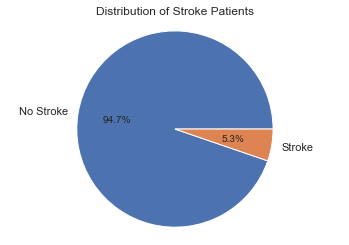

In [182]:
import seaborn as sns

plt.pie(stroke_percent.to_list(),labels=['No Stroke','Stroke'],autopct='%1.1f%%')
plt.title('Distribution of Stroke Patients')
plt.axis('equal')
plt.show()

In [183]:
stroke_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5100,68398,Male,82.0,1,0,Yes,Self-employed,Rural,71.97,28.3,never smoked,0
5102,45010,Female,57.0,0,0,Yes,Private,Rural,77.93,21.7,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0



stroke
         gender  Percentage
Female     105   58.333333
Male        75   41.666667

nostroke
         gender  Percentage
Female    1981   61.047766
Male      1264   38.952234

stroke
      ever_married  Percentage
Yes           160   88.888889
No             20   11.111111

nostroke
      ever_married  Percentage
Yes          2439   75.161787
No            806   24.838213

stroke
    heart_disease  Percentage
0            144        80.0
1             36        20.0

nostroke
    heart_disease  Percentage
0           3075   94.761171
1            170    5.238829

stroke
    heart_disease  Percentage
1             36        20.0
0            144        80.0


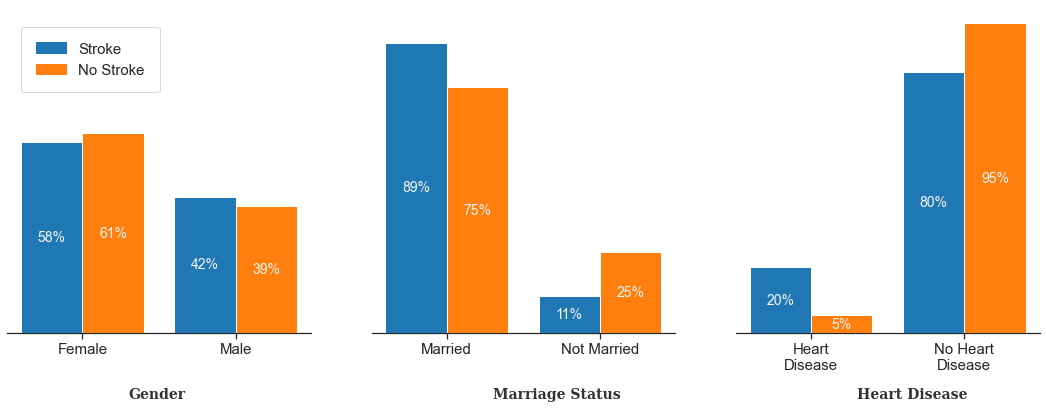

In [184]:
fig, axs = plt.subplots(1,3)

str_only = stroke_df[stroke_df['stroke'] == 1]
no_str_only = stroke_df[stroke_df['stroke'] == 0]

def getPercent_df(df,category):
    temp_df = pd.DataFrame(df[category].value_counts())
    temp_df["Percentage"] = temp_df[category].apply(lambda x:x/sum(temp_df[category])*100)
    return temp_df

ticks= {'gender':['Female','Male'],
        'ever_married':['Married','Not Married'],
        'heart_disease':['Heart\nDisease','No Heart\nDisease']
       }

xlabels={'gender':'Gender','ever_married':'Marriage Status','heart_disease':'Heart Disease'}

def addBarChart(ax,category):

        
    hadStroke=getPercent_df(str_only,category)
    print('\nstroke\n',hadStroke)
    noStroke=getPercent_df(no_str_only,category)
    print('\nnostroke\n',noStroke)
    if 'heart' in category:
        hadStroke=getPercent_df(str_only,category).sort_index(ascending=False)
        print('\nstroke\n',hadStroke)
        noStroke=getPercent_df(no_str_only,category).sort_index(ascending=False)
    x = np.arange(len(hadStroke))
    ax.text(.5, -20, xlabels[category], fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
    ax.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))

    ax.bar(x, height=hadStroke["Percentage"], zorder=3, color="tab:blue", width=0.4)
    ax.bar(x+0.4, height=noStroke["Percentage"], zorder=3, color="tab:orange", width=0.4)

    ax.set_xticks(x + 0.4 / 2)

    ax.set_xticklabels(hadStroke.index.tolist())

    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.yaxis.set_major_locator(mtick.MultipleLocator(10))
    ax.set_xticklabels(ticks[category], fontsize=15)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.axes.yaxis.set_visible(False)
    #xlbl = ax.xaxis.get_label().get_text()
   # ax.set_xlabel(xlabels[xlbl],fontsize=19)
   # ax.xaxis.set_label_coords(0.5,4)
    ax.set_ylim([0,100])
    
    for i,j in zip([0, 1], hadStroke["Percentage"]):
        ax.annotate(f'{j:0.0f}%',
                    xy=(i, j/2), 
                    color='#f6f6f6', 
                    horizontalalignment='center', 
                    verticalalignment='center',
                    size = 14)
    for i,j in zip([0, 1], noStroke["Percentage"]):
        ax.annotate(f'{j:0.0f}%',
                    xy=(i+0.4, j/2), 
                    color='#f6f6f6', 
                    horizontalalignment='center', 
                    verticalalignment='center',
                    size = 14)
        
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='tab:orange', label='No Stroke')
blue_patch = mpatches.Patch(color='tab:blue', label='Stroke')
leg = fig.legend(loc='upper left',
                 bbox_to_anchor=(0.13, .85),
                 borderpad=1, prop={'size': 15},
                 handles=[blue_patch,red_patch])

addBarChart(axs[0],'gender')       
addBarChart(axs[1],'ever_married')  
addBarChart(axs[2],'heart_disease')  

fig.set_size_inches(18.5,6)